# CMPT 742 - Fall 2025
# Image Classification with PyTorch

In [1]:
!pip install torch torchvision tensorboard torchmetrics

  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
Using cached tensorboard-2.20.0-py3-none-any.whl (5.5 MB)


Import Libraries

In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np

Load CIFAR-100 Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4412241..1.512129].


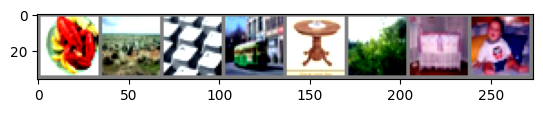

In [3]:
# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))  # CIFAR-100 normalization values
])

# Load CIFAR-100 dataset
batch_size = 64
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Define a function to visualize some samples from the dataset
def imshow(img):
    img = img.permute(1,2,0)
    img = img.numpy()
    img = img / 2 + 0.5
    plt.imshow(img)
    plt.show()

# Show some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]))  # Show 8 images in a grid

In [4]:
train_dataset.classes

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

Define the Model

In [ ]:
# Load the pre-defined ResNet18 model and adjust it for CIFAR-100
from torchvision.models import resnet18

# Define the model
model = resnet18(weights=True)  # Set num_classes to 100 for CIFAR-100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to('cuda') # set the model on cuda

/localhome/aaa324/conda/conda/envs/clip/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [64]:
def count_parameters_in_millions(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params / 1_000_000  # Divide by 1 million to convert to millions

# Example usage:
total_params_in_millions = count_parameters_in_millions(model)
print(f'Total trainable parameters: {total_params_in_millions:.2f} million')

Total trainable parameters: 11.69 million


Change the model

In [65]:
model.fc = nn.Linear(in_features=512, out_features=100)

In [66]:
# Example usage:
total_params_in_millions = count_parameters_in_millions(model)
print(f'Total trainable parameters: {total_params_in_millions:.2f} million')

Total trainable parameters: 11.23 million


Model Parameters

In [67]:
# prompt: print model parameters
print("Model Parameters:")
for name, param in model.named_parameters():
  print(f"Name: {name}, Shape: {param.shape}")


Model Parameters:
Name: conv1.weight, Shape: torch.Size([64, 3, 7, 7])
Name: bn1.weight, Shape: torch.Size([64])
Name: bn1.bias, Shape: torch.Size([64])
Name: layer1.0.conv1.weight, Shape: torch.Size([64, 64, 3, 3])
Name: layer1.0.bn1.weight, Shape: torch.Size([64])
Name: layer1.0.bn1.bias, Shape: torch.Size([64])
Name: layer1.0.conv2.weight, Shape: torch.Size([64, 64, 3, 3])
Name: layer1.0.bn2.weight, Shape: torch.Size([64])
Name: layer1.0.bn2.bias, Shape: torch.Size([64])
Name: layer1.1.conv1.weight, Shape: torch.Size([64, 64, 3, 3])
Name: layer1.1.bn1.weight, Shape: torch.Size([64])
Name: layer1.1.bn1.bias, Shape: torch.Size([64])
Name: layer1.1.conv2.weight, Shape: torch.Size([64, 64, 3, 3])
Name: layer1.1.bn2.weight, Shape: torch.Size([64])
Name: layer1.1.bn2.bias, Shape: torch.Size([64])
Name: layer2.0.conv1.weight, Shape: torch.Size([128, 64, 3, 3])
Name: layer2.0.bn1.weight, Shape: torch.Size([128])
Name: layer2.0.bn1.bias, Shape: torch.Size([128])
Name: layer2.0.conv2.weight, 

In [68]:
model.fc = nn.Linear(model.fc.in_features, 100)
model = model.to(device)

Define Loss Function, Optimizer, and TensorBoard Writer

In [69]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.fc.parameters(), lr=0.1)
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Initialize TensorBoard writer
writer = SummaryWriter('runs/cifar100_resnet18')

In [70]:
# Function to save a checkpoint in the TensorBoard log directory
def save_checkpoint(model, optimizer, epoch, loss_metric, accuracy_metric, checkpoint_dir='runs/cifar100_resnet18'):
    checkpoint_path = f"{checkpoint_dir}/checkpoint_epoch_{epoch+1}.pth"

    # Use .compute() to get the values of the metrics
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss': loss_metric.compute(),  # Get the computed loss
        'accuracy': accuracy_metric.compute()  # Get the computed accuracy
    }
    torch.save(checkpoint, checkpoint_path)
    print(f'Checkpoint saved at {checkpoint_path}')

# Function to load a checkpoint from the TensorBoard log directory
def load_checkpoint(model, optimizer, checkpoint_dir='runs/cifar100_resnet18'):
    import glob
    # Find the latest checkpoint (e.g., based on the highest epoch number)
    checkpoint_paths = glob.glob(f"{checkpoint_dir}/checkpoint_epoch_*.pth")
    checkpoint_paths.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
    latest_checkpoint = checkpoint_paths[-1]
    print(latest_checkpoint)

    checkpoint = torch.load(latest_checkpoint)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
    loss = checkpoint['loss']
    accuracy = checkpoint['accuracy']
    print(f'Checkpoint loaded from {latest_checkpoint}. Resuming training from epoch {start_epoch}')

    return start_epoch, loss, accuracy  # You can return these for reference but don't update accuracy_metric with them

In [74]:
import torchmetrics
from torch.utils.tensorboard import SummaryWriter

# Updated training function with torchmetrics and resuming capability
def train_model(model, train_loader, criterion, optimizer, num_epochs=1, start_epoch=0, resume=False, checkpoint_dir='runs/cifar100_resnet18'):
    # Initialize the metrics
    loss_metric = torchmetrics.MeanMetric()
    accuracy_metric = torchmetrics.Accuracy('multiclass', num_classes=100)

    # Load checkpoint if resuming
    if resume:
        load_checkpoint(model, optimizer, checkpoint_dir)

    model.train()
    
    for epoch in range(start_epoch, num_epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            optimizer.zero_grad()
            loss = criterion(outputs, labels)
            loss_metric.update(loss.item())
            accuracy_metric.update(outputs.cpu(), labels.to('cpu'))
            loss.backward()
            optimizer.step()
            
            if i == 0:
                loss_value = loss_metric.compute().item()
                acc_value = accuracy_metric.compute().item() * 100
                print(f"Epoch {epoch}: Loss={loss_value:.2f} Accuracy={acc_value:.2f}")
                save_checkpoint(model, optimizer, epoch, loss_metric, accuracy_metric, checkpoint_dir='runs/cifar100_resnet18')
            

In [75]:
def evaluate_model(model, test_loader, criterion, optimizer, checkpoint_dir='runs/cifar100_resnet18'):
    # Load the model from the latest checkpoint if needed
    load_checkpoint(model, optimizer, checkpoint_dir)

    # Set the model to evaluation mode
    model.eval()
    loss_metric = torchmetrics.MeanMetric()
    accuracy_metric = torchmetrics.Accuracy('multiclass', num_classes=100)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_metric.update(loss.item())
            accuracy_metric.update(outputs.cpu(), labels.to('cpu'))    
        loss_value = loss_metric.compute().item()
        acc_value = accuracy_metric.compute().item() * 100
        print(f"Loss: {loss_value:.2f} Accuracy: {acc_value:.2f}")

In [76]:
# Start training from scratch
train_model(model, train_loader, criterion, optimizer, num_epochs=20, resume=False, checkpoint_dir='runs/cifar100_resnet18')

# If training gets interrupted, resume from the last checkpoint:
# train_model(model, train_loader, criterion, optimizer, num_epochs=10, resume=True, checkpoint_dir='runs/cifar100_resnet18', start_epoch=1)

Epoch 0: Loss=2.07 Accuracy=48.44
Checkpoint saved at runs/cifar100_resnet18/checkpoint_epoch_1.pth
Epoch 1: Loss=2.01 Accuracy=47.16
Checkpoint saved at runs/cifar100_resnet18/checkpoint_epoch_2.pth
Epoch 2: Loss=1.90 Accuracy=49.86
Checkpoint saved at runs/cifar100_resnet18/checkpoint_epoch_3.pth
Epoch 3: Loss=1.77 Accuracy=52.77
Checkpoint saved at runs/cifar100_resnet18/checkpoint_epoch_4.pth
Epoch 4: Loss=1.66 Accuracy=55.62
Checkpoint saved at runs/cifar100_resnet18/checkpoint_epoch_5.pth
Epoch 5: Loss=1.54 Accuracy=58.64
Checkpoint saved at runs/cifar100_resnet18/checkpoint_epoch_6.pth
Epoch 6: Loss=1.43 Accuracy=61.57
Checkpoint saved at runs/cifar100_resnet18/checkpoint_epoch_7.pth
Epoch 7: Loss=1.32 Accuracy=64.42
Checkpoint saved at runs/cifar100_resnet18/checkpoint_epoch_8.pth
Epoch 8: Loss=1.22 Accuracy=67.18
Checkpoint saved at runs/cifar100_resnet18/checkpoint_epoch_9.pth
Epoch 9: Loss=1.12 Accuracy=69.74
Checkpoint saved at runs/cifar100_resnet18/checkpoint_epoch_10.pth

In [80]:
evaluate_model(model, test_loader, criterion, optimizer)

runs/cifar100_resnet18/checkpoint_epoch_20.pth
Checkpoint loaded from runs/cifar100_resnet18/checkpoint_epoch_20.pth. Resuming training from epoch 20
Loss: 3.72 Accuracy: 35.95


In [22]:
# Load the TensorBoard extension
%load_ext tensorboard

# Start TensorBoard and point it to the log directory used by SummaryWriter
%tensorboard --logdir=runs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Traceback (most recent call last):
  File "/localhome/aaa324/conda/conda/envs/clip/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/localhome/aaa324/conda/conda/envs/clip/lib/python3.10/site-packages/tensorboard/main.py", line 41, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/localhome/aaa324/conda/conda/envs/clip/lib/python3.10/site-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/localhome/aaa324/conda/conda/envs/clip/lib/python3.10/site-packages/absl/app.py", line 254, in _run_main
    sys.exit(main(argv))
  File "/localhome/aaa324/conda/conda/envs/clip/lib/python

In [81]:
def visualize_feature_maps(model, layer_name, image):
    # Get the specified layer's output
    activation = {}
    def hook_fn(module, input, output):
        activation[layer_name] = output

    layer = dict(model.named_modules())[layer_name]
    layer.register_forward_hook(hook_fn)

    # Pass the image through the model
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    model(image)

    # Extract and plot the feature maps
    feature_maps = activation[layer_name].squeeze().cpu().detach()
    fig, axes = plt.subplots(1, min(8, feature_maps.size(0)), figsize=(15, 15))
    for i in range(min(8, feature_maps.size(0))):
        axes[i].imshow(feature_maps[i], cmap='viridis')
        axes[i].axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.33852684..1.41984].


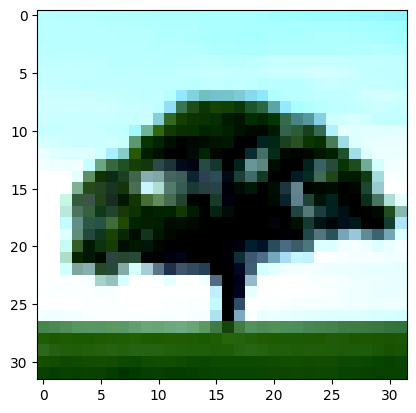

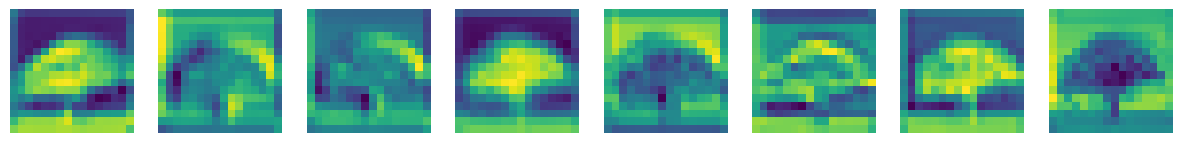

In [82]:
dataiter = iter(test_loader)
image = next(dataiter)[0][0]
imshow(image)
visualize_feature_maps(model, "conv1", image)

In [59]:
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_tsne(model, loader):
    features = []
    labels = []
    model.eval()

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            output = model(inputs)
            features.extend(output.cpu().numpy())
            labels.extend(targets.numpy())

    # Convert the list of features into a numpy array
    features = np.array(features)
    labels = np.array(labels)

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)

    # Create a DataFrame for visualization
    df = pd.DataFrame({'x': tsne_results[:, 0], 'y': tsne_results[:, 1], 'label': labels})

    # Plot the t-SNE results using seaborn
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='x', y='y', hue='label', palette='tab10', data=df, legend='full', alpha=0.7)
    plt.title('t-SNE of MobileNetV2 Features')
    plt.show()

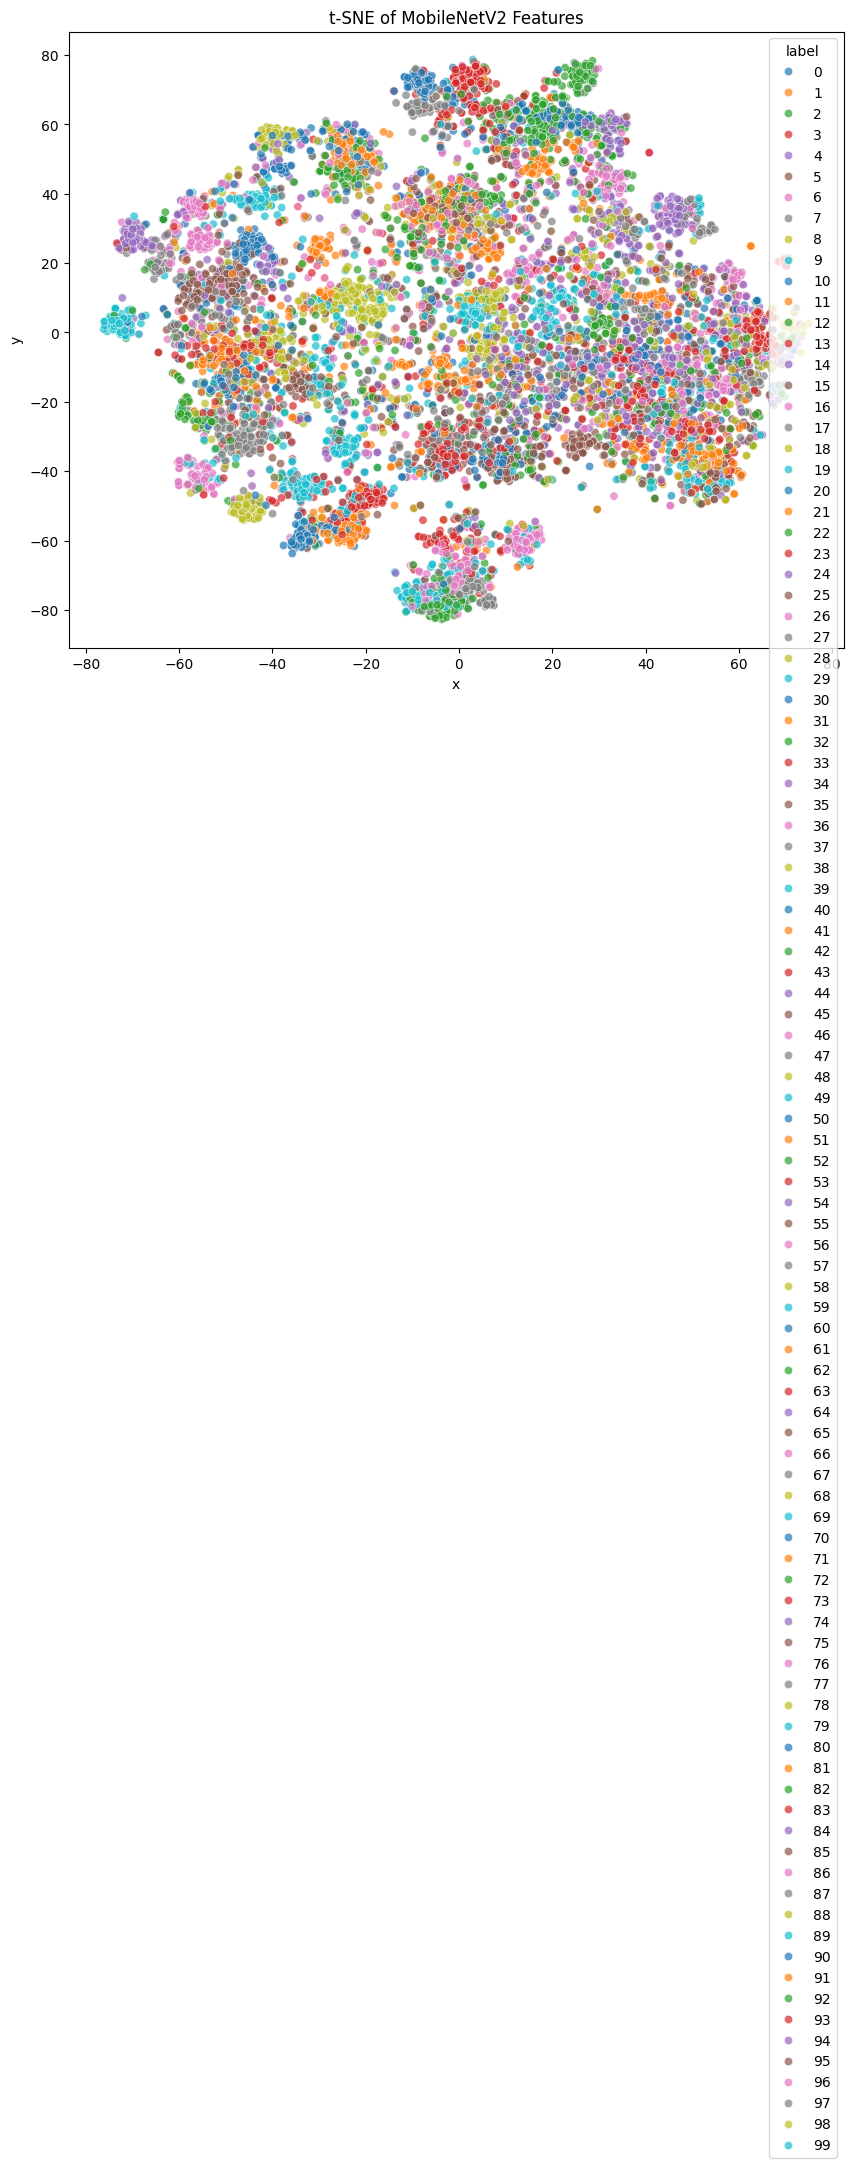

In [60]:
visualize_tsne(model, test_loader)

In [83]:
def get_incorrect_predictions(model, loader, max_samples=10):
    model.eval()
    incorrect_samples = []
    incorrect_labels = []
    incorrect_preds = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            incorrect_indices = (preds != labels).nonzero(as_tuple=True)[0]

            for idx in incorrect_indices:
              if len(incorrect_samples) < max_samples:
                incorrect_samples.append(inputs[idx].cpu())
                incorrect_labels.append(labels[idx].cpu().item())
                incorrect_preds.append(preds[idx].cpu().item())
              else:
                return incorrect_samples, incorrect_labels, incorrect_preds

    return incorrect_samples, incorrect_labels, incorrect_preds


def visualize_incorrect_predictions(model, loader, class_names, max_samples=10):
    incorrect_samples, incorrect_labels, incorrect_preds = get_incorrect_predictions(model, loader, max_samples=max_samples)

    # Plot the images with true and predicted labels
    fig, axes = plt.subplots(1, len(incorrect_samples), figsize=(15, 5))
    if len(incorrect_samples) == 1:
        axes = [axes]  # To handle the case where there's only one incorrect sample

    for idx, (img, true_label, pred_label) in enumerate(zip(incorrect_samples, incorrect_labels, incorrect_preds)):
        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        img = img * 0.2673 + 0.5071  # Unnormalize for CIFAR100: (std_dev * image + mean)
        img = np.clip(img, 0, 1)

        axes[idx].imshow(img)
        axes[idx].set_title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}', fontsize=10)
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

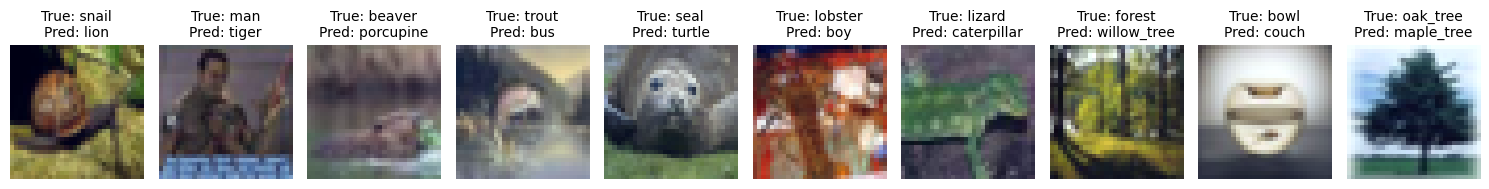

In [84]:
visualize_incorrect_predictions(model, test_loader, train_dataset.classes, max_samples=10)